In [1]:
import os
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio import plot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize



# Paths and variables
tiles_gdf = gpd.read_file("../data/tiles.geojson")
print(len(tiles_gdf))
county_boundary = gpd.read_file("../data/county_boundary.shp")
mosaic_path = os.path.join("../data", "merged_urban_raster.tif")
mosaic = rasterio.open(mosaic_path)

# Mask the mosaic data to limit it to the county boundary
county_geom = [tiles_gdf.geometry.union_all()]  # Convert to list for mask function
data, transform = mask(mosaic, county_geom, crop=False, filled=True, nodata=-1)
data = data.astype('float32')
data[data == 255] = np.nan  # Replace -1 with NaN for visualization
data = data / 100

Skipping field data_files: unsupported OGR type: 5


5954


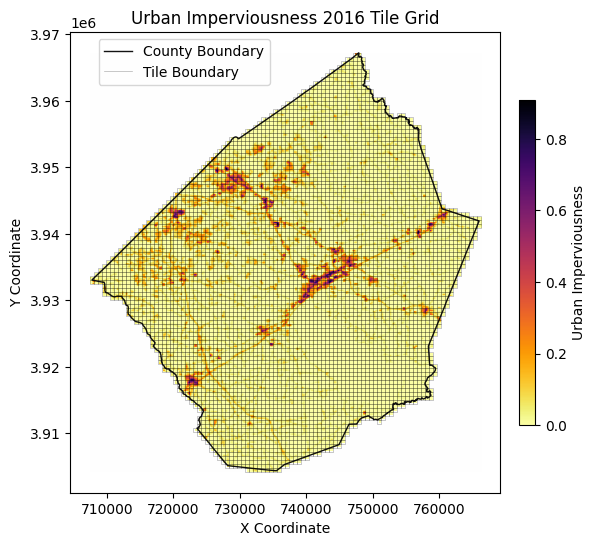

In [3]:


# Create a reversed colormap with white for NaNs
cmap = plt.cm.inferno.reversed()
cmap.set_bad(color='#fefefe')  # Set NaN values to appear white

# Plot the mosaic with NA color set to white
fig, ax = plt.subplots(figsize=(6, 6))
img = rasterio.plot.show(data, transform=transform, ax=ax, cmap=cmap)

# Plot the county boundary and tile boundaries
county_boundary.plot(ax=ax, facecolor='none', edgecolor='#121212', linewidth=1.)
tiles_gdf.boundary.plot(ax=ax, edgecolor='#030303', linewidth=0.5, alpha=0.3)

# Create a ScalarMappable for the color bar (Urban Imperviousness)
norm = Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
sm = ScalarMappable(norm=norm, cmap=cmap)

# Create custom legend elements for County Boundary and Tile Boundary
legend_elements = [
    Line2D([0], [0], color='#121212', lw=1., label='County Boundary'),
    Line2D([0], [0], color='#030303', lw=0.5, label='Tile Boundary', alpha=0.3),
]

# Add the legend for County Boundary and Tile Boundary outside the plot
legend = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.05, 1), frameon=True)

# Position the color bar to the right of the plot to represent Urban Imperviousness
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.035, pad=0.04)
cbar.set_label('Urban Imperviousness')

# Title and labels
plt.title('Urban Imperviousness 2016 Tile Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Set x and y extent using the transform
x_min, y_min = mosaic.bounds.left, mosaic.bounds.bottom
x_max, y_max = mosaic.bounds.right, mosaic.bounds.top

# Adjust xlim and ylim to add padding around the raster
x_padding = (x_max - x_min) * 0.05  # 5% padding on x-axis
y_padding = (y_max - y_min) * 0.05  # 5% padding on y-axis
ax.set_xlim(x_min - x_padding, x_max + x_padding)
ax.set_ylim(y_min - y_padding, y_max + y_padding)

plt.show()